A simple demo of employing LLLA. 

In [1]:
# Standard imports
import os
import copy
import collections
import numpy as np
from numpy.linalg import inv, cholesky
from typing import Union, List, Any, Dict
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Module, Sequential
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')

# From the repository
from plot import surface_plot, regression_uncertainty
from curvatures import Diagonal, KFAC, EFB, INF,Curvature, BlockDiagonal
from utils import calibration_curve,get_eigenvectors, kron

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

D:\Ana\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We create a toy 4-class classification data. 

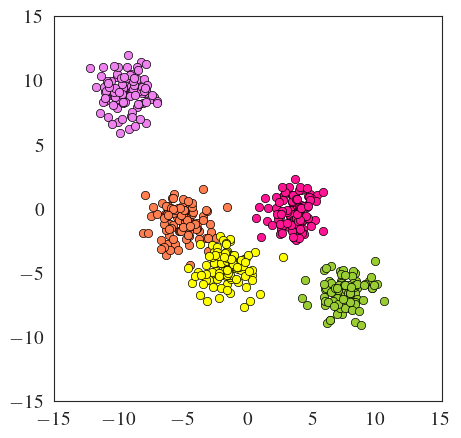

In [2]:
np.random.seed(2222)
size = 500
train_range = (-10, 10)

X, Y = datasets.make_blobs(n_samples=size, centers=5, cluster_std=1.2, 
                           center_box=train_range, random_state=33)

test_range = (-15, 15)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='violet', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==4][:, 0], X[Y==4][:, 1], c='deeppink', edgecolors='k', linewidths=0.5)
plt.xlim(test_range);
plt.ylim(test_range);

In [3]:
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 5  # num. classes


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.023


In [4]:
def plot(X, Y, X1_test, X2_test, Z, test_range):
    cmap = 'Blues'
    plt.figure(figsize=(6, 5))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.3, 1.01, 0.1))
    cbar = plt.colorbar(im)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Confidence', rotation=270)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==4][:, 0], X[Y==4][:, 1], c='deeppink', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);

    plt.xlabel("Feature 1",fontsize=16)
    plt.ylabel("Feature 2",fontsize=16)

    plt.show();

In [5]:
# Test data
size = 50
test_range = (-15, 15)
test_rng = np.linspace(*test_range, size)

X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
X_test = torch.from_numpy(X_test).float()

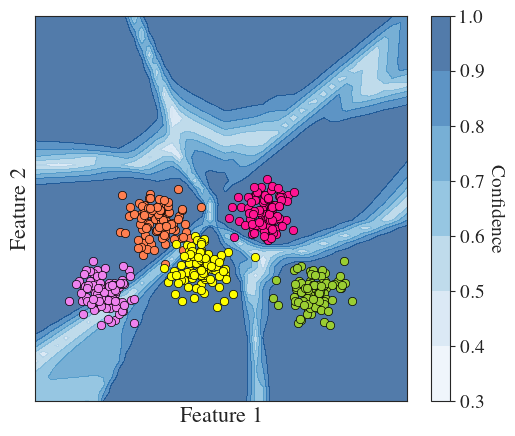

In [6]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [7]:
ll_model = copy.deepcopy(model)

## Full NN

In [8]:
model.train()
diag = Diagonal(model)

prediction = model(X_train) 
loss = F.cross_entropy(prediction, y_train)
model.zero_grad()
loss.backward()
diag.update(batch_size=size)

In [9]:
kfac = KFAC(model)

prediction = model(X_train) 
loss = F.cross_entropy(prediction, y_train)
model.zero_grad()
loss.backward()
kfac.update(batch_size=size)

D:\Ana\envs\torch\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [10]:
efb = EFB(model, kfac.state)

prediction = model(X_train) 
loss = F.cross_entropy(prediction, y_train)
model.zero_grad()
loss.backward()
efb.update(batch_size=size)

D:\OneDrive - Deakin University\Fisher-Matrix-Sparse-Bayesian\utils.py:49: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:3041.)
  _, xxt_eigvecs = torch.symeig(sym_xxt, eigenvectors=True)


In [11]:
samples = 100
add = 2.50
multiply = 500.0

In [12]:
efb.invert(add, multiply)

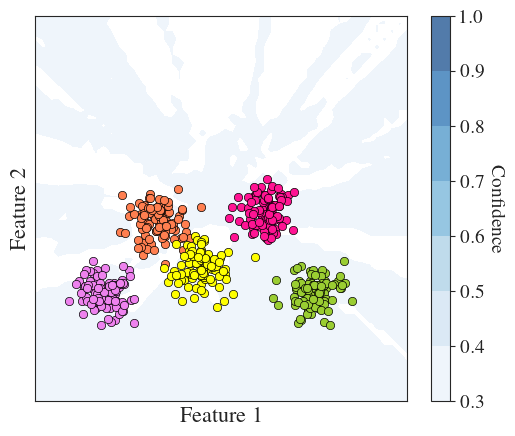

In [13]:
model.eval()
py = 0
with torch.no_grad():
    for sample in range(samples):
        efb.sample_and_replace()
        py_map = F.softmax(model(X_test), 1).squeeze().numpy()
        py += py_map
py /= samples
conf = py.max(1)
plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

## Last Layer

In [14]:
ll_model.train()
diag1 = Diagonal(ll_model, last_layer_mode = True)

prediction1 = ll_model(X_train) 
loss1 = F.cross_entropy(prediction1, y_train)
ll_model.zero_grad()
loss1.backward()
diag1.update(batch_size=size)

In [15]:
kfac1 = KFAC(ll_model, last_layer_mode = True)

prediction1 = ll_model(X_train) 
loss1 = F.cross_entropy(prediction1, y_train)
ll_model.zero_grad()
loss1.backward()
kfac1.update(batch_size=size)

In [16]:
efb1 = EFB(ll_model, kfac1.state, last_layer_mode = True)

prediction1 = ll_model(X_train) 
loss1 = F.cross_entropy(prediction1, y_train)
ll_model.zero_grad()
loss1.backward()
efb1.update(batch_size=size)

In [17]:
efb1.invert(add, multiply)

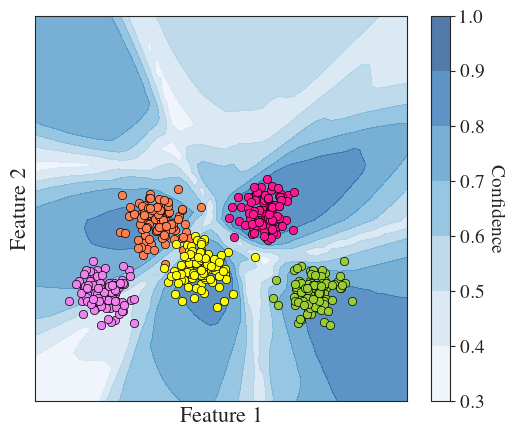

In [18]:
ll_model.eval()
py1 = 0
with torch.no_grad():
    for sample in range(samples):
        efb1.sample_and_replace()
        py_map1 = F.softmax(ll_model(X_test), 1).squeeze().numpy()
        py1 += py_map1
py1 /= samples
conf1 = py1.max(1)
plot(X, Y, X1_test, X2_test, conf1.reshape(size, size), test_range)